<a href="https://colab.research.google.com/github/forminju/deeplearning-practice/blob/main/0104_RNN%EA%B3%BC_CNN%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%B4_%EC%8B%9C%ED%80%80%EC%8A%A4_%EC%B2%98%EB%A6%AC%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN 과 CNN을 사용해 시퀀스 처리하기

## 순환 뉴런과 순환 층
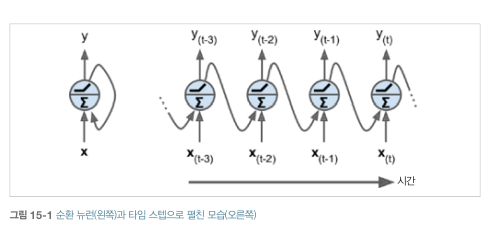

- RNN 은 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있다.
- 인코더 - 디코더
- RNN을 훈련하기 위한 기법은 타임 스텝으로 네트워크를 펼치고 보통의 역전파를 사용하는 것 - BPTT

## 시계열 예측하기

- 웹사이트에서 시간당 접속 사용자의 수
- 도시의 날짜별 온도 : 단변량 시계열 (타임 스텝마다 하나의 값을 가지므로)
- 여러 지표를 사용한 기업의 분기별 재정 안정성 : 다변량 시계열(타임 스텝마다 여러 값)

In [17]:
import numpy as np
import keras

In [9]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0,1,n_steps)
  series = 0.5*np.sin((time-offsets1) * (freq1*10+10))
  series += 0.2*np.sin((time-offsets2) * (freq2*20+20))
  series += 0.1*(np.random.rand(batch_size, n_steps)-0.5)
  return series[..., np.newaxis].astype(np.float32)

In [10]:
n_steps = 50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000,-1]
X_test, y_test = series[9000:, :n_steps],series[9000:,-1]

In [14]:
X_train.shape
# [배치크기, 타임 스텝 수, 1]
# 각 시계열에는 타임 스텝마다 하나의 값만 있으므로 단변량 데이터.
# 각 시계열은 진폭이 같고 진동 수와 위상이 랜덤한 두 개의 사인 곡선을 더하고 약간의 잡음을 추가한다.

(7000, 50, 1)

## 기준 성능
- RNN 시작 전에 기준 성능을 몇 개 준비하는 것이 좋다.
- 그렇지 않으면 실제 기본 모델보다 성능이 나쁠 때도 잘 작동한다고 생각할 수 있기 때문!



In [19]:
y_pred = X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
# 시계열의 마지막 값을 그대로 예측

0.020944558

In [20]:
# 완전 연결 네트워크 이용
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

In [21]:
# 간단한 RNN 구현하기
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None,1])
])
# 순환 신경망은 어떤 길이의 타임 스텝도 처리할 수 있기 때문에 이전 모델과 달리 입력 시퀀스의 길이를 지정할 필요가 없다.
# 기본적으로 SimpleRNN 층은 하이퍼볼릭 탄젠트 활성화 함수를 사용한다.

## 심층 RNN

In [22]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences =True, input_shape =[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
# 모든 순환 층에서 return_sequences=True 로 설정해야 한다.

In [23]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None,1]),
    keras.layers.SimpleRNN(20), 
    # 마지막 순환 층의 return_sequences 는 뺴주어도 된다.
    keras.layers.Dense(1)
])

In [24]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]  

1/1 [==============================] - 0s 20ms/step


- 시계열을 예측할 때 오차 막대를 사용하는 것이 유용하다. 각 메모리 셀에 드롭아웃 층을 추가하여 입력과 은닉 상태를 드롭아웃한다. 훈련이 끝난 후 새로운 시계열을 예측하기 위해서 이 모델을 여러 번 사용해 각 타임 스텝에서 예측의 평균과 표준편차를 계산한다.

## LSTM 셀

In [27]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape = [None,1]),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

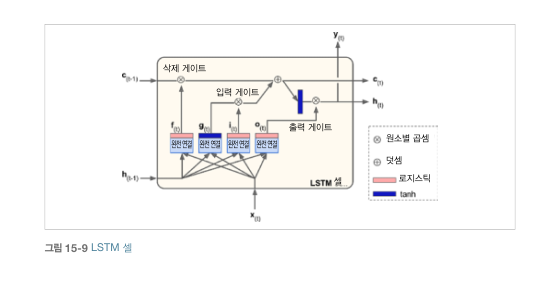

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [2]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

## 사전훈련된 임베딩 재사용하기

In [8]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dytpe = tf.string, input_shape = [], output_shape = [50]),
    keras.layers.Dense(128,activation = "relu"),
    keras.layers.Dense(1, activation ="sigmoid")               
])

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])

TypeError: ignored

In [ ]:
datasets, info = tfds.load("imdb_revies", as_supervised = True, with_info  = True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_Set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs = 5)

## 신경망 기계 번역을 위한 인코더-디코더 네트워크.

In [32]:
import tensorflow_addons as tensorflow_addons

encoder_inputs = keras.layers.Input(shape = [None], dtype = np.int32)
decoder_inputs = keras.layers.Input(shape = [None], dtype = np.int32)
sequence_lengths = keras.layers.Input(shape = [], dtype = np.int32)

In [33]:
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

NameError: ignored

## 어텐션 메커니즘

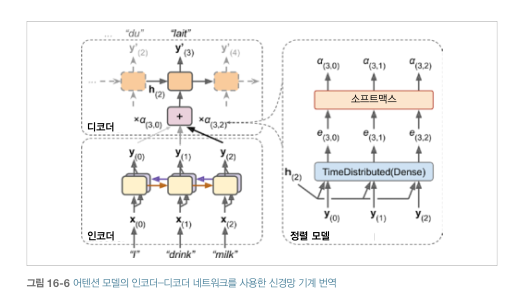
```
# 코드로 형식 지정됨
```



In [ ]:
enc